<a href="https://colab.research.google.com/github/adupatil/Hindi-to-English-Translator/blob/main/NLP_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/cnn_dailymail/train.csv").drop(columns="id")
test = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/cnn_dailymail/test.csv").drop(columns="id")
validation = pd.read_csv("/content/drive/MyDrive/NLP_Project/datasets/cnn_dailymail/validation.csv").drop(columns="id")

---
## EDA 
---

In [4]:
train.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [5]:
train.describe()

,article,highlights
count,287113,287113
unique,284005,282197
top,(CNN) -- Dubai could lose its place on the Wom...,This page includes the show Transcript and the...
freq,3,83


In [6]:
train['article'][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [7]:
train['highlights'][0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

In [8]:
train['article_length'] = train['article'].apply(lambda x : len(x.split()))
train['highlights_length'] = train['highlights'].apply(lambda x : len(x.split()))

<Axes: xlabel='article_length', ylabel='Count'>

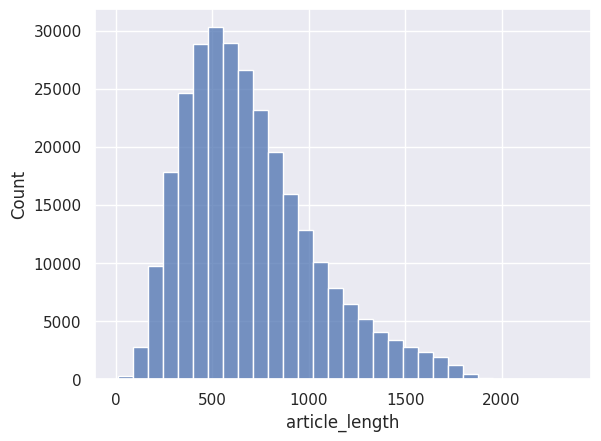

In [9]:
sns.set_theme('notebook')
sns.histplot(data=train,x='article_length',bins=30)

We can observe the following:
1. There are some article with length 0
2. Most articles range between 450 - 900 words

<Axes: xlabel='highlights_length', ylabel='Count'>

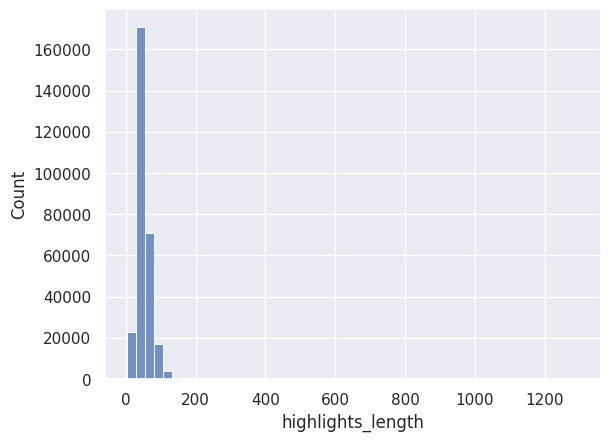

In [10]:
sns.histplot(data=train,x='highlights_length',bins=50)

We observe the following:
1. There are some outlier(s) in highlights which will affect our model performance

<Axes: xlabel='article_length'>

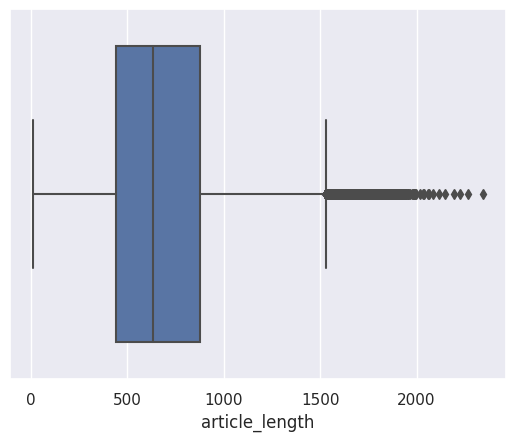

In [11]:
sns.boxplot(data=train,x='article_length')

<Axes: xlabel='highlights_length'>

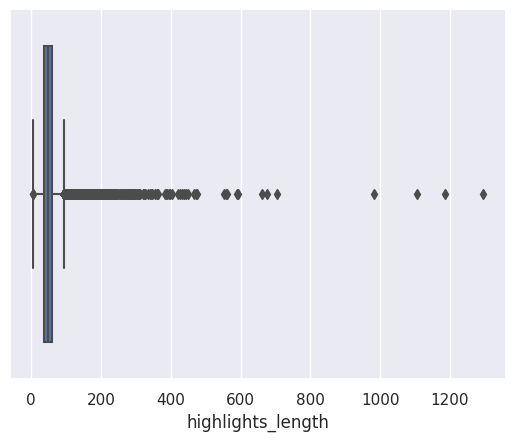

In [12]:
sns.boxplot(data=train,x='highlights_length')

We can observe the average length of highlights varies a lot, so we will have to , decide some range and prune the other values

In [13]:
## check for null
train.isnull().sum()

article              0
highlights           0
article_length       0
highlights_length    0
dtype: int64

In [14]:
## Checking for duplicates
train.duplicated(subset= ['article', 'highlights']).sum()

3098

In [15]:
train = train.drop_duplicates(subset=['article', 'highlights'])

---
## Remove Outliers
---

In [16]:
print(f"{len(train[(train['article_length']>200) & (train['article_length']<1300)])/len(train)*100}% of the artciles lie between 200 and 1300 words")

91.35925919405665% of the artciles lie between 200 and 1300 words


In [17]:
# We will drop the outliers
train = train[(train['article_length']>200) & (train['article_length']<1300)]

<Axes: xlabel='article_length'>

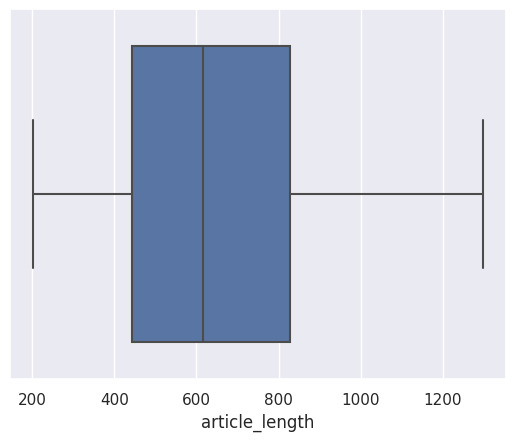

In [18]:
sns.boxplot(data=train,x='article_length')

Outliers have been removed from articles

In [19]:
print(f"{len(train[(train['highlights_length']>20) & (train['highlights_length']<200)])/len(train)*100}% of the highights lie between 30 and 200 words")

97.87146303675898% of the highights lie between 30 and 200 words


In [20]:
## Removing the outliers in highlights
train = train[(train['highlights_length']>20) & (train['highlights_length']<200)]

<Axes: xlabel='highlights_length'>

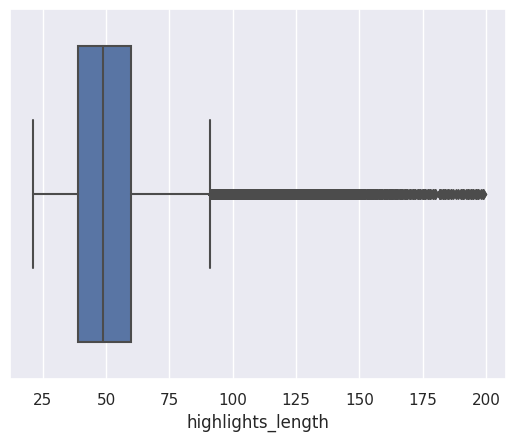

In [21]:
sns.boxplot(data=train,x='highlights_length')

---
## Text Preprocessing
---

In [22]:
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim import parsing
import re
from time import time

In [23]:
remove_emails = lambda s: re.sub(r'\S+@\S+', '', s)
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

CLEAN_FILTERS = [
                remove_emails,
                strip_tags,
                strip_numeric, 
                strip_multiple_whitespaces]

def clean(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

def joinList(processed_words):
    return ' '.join(processed_words)

In [24]:
## Considering 30% of the total dataset ~ 60k rows
train_df = train.sample(frac=0.3)

In [25]:
## Cleaning articles
t0 = time()
train_df['cleaned_articles'] = train_df['article'].apply(clean).apply(joinList)
validation['cleaned_articles'] = validation['article'].apply(clean).apply(joinList)
print(f"done in {time()-t0}")

done in 61.80499601364136


In [26]:
## Cleaning highlights
t0 = time()
train_df['highlights'] = train_df['highlights'].apply(lambda x : strip_tags(x))
validation['highlights'] = validation['highlights'].apply(lambda x : strip_tags(x))
print(f"done in {time()-t0}")

done in 0.148756742477417


In [27]:
train_df['cleaned_articles'].iloc[0]

'Hong Kong (CNN) -- In scenes that would not have been out of place in a Hollywood science fiction thriller, at dawn on March , , armed police and Hong Kong health authorities dressed in biological suits, theater masks and surgical gloves descended on Amoy Gardens housing estate. Working swiftly on an order from the Department of Health to isolate Block E, the residents were sealed in. Under -hour medical surveillance, they could neither leave the block nor receive visitors, according to a report from the Hong Kong Department of Health. Later moved to confinement camps under quarantine laws that had not been invoked since an outbreak of bubonic plague in , the residents of Amoy Gardens were locked out for days as doctors, clinicians, sewerage experts and engineers scoured the block for clues. But even before Block E could be quarantined, police were on a manhunt for residents who had already fled the infected apartment block -- to hotels or to stay with family or friends -- possibly sp

In [28]:
train_df['highlights'].iloc[0]

'Hong Kong housing estate Amoy Gardens was center of 2003 SARS outbreak .\nAuthorities had to work fast to isolate the virus and quarantine residents .\nThe events at Amoy Gardens underscored the difficulties of containing epidemics .\nPublic information an important part of the fight against epidemics .'

---
## Data Preprocessing
---

In [ ]:
! pip install transformers

In [30]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [31]:
## Setting the max_length for padding or truncating articles and summaries
max_length_art = 1000
max_length_sum = 180

In [47]:
def preprocess_data(col):
  model_inputs = tokenizer(
      col['cleaned_articles'].tolist(),
      max_length=max_length_art,
      truncation=True,
  )
  labels = tokenizer(
      col["highlights"].tolist(), max_length=max_length_sum, truncation=True
  )
  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

def create_tokenized_data(data):
  tokenized_data = []
  for i in range(len(data)):
    tokenized_data.append(preprocess_data(data[i:i+1]))
  return tokenized_data

In [ ]:
t0=time()
tokeinzed_train = create_tokenized_data(train_df)
tokenized_val = create_tokenized_data(validation)
print(f"Completed in {time()-t0} secs")